In [1]:
import os
from glob import glob
import pandas as pd 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Import local modules
import sys
sys.path.append('./..')
import visualization

## Read data

In [2]:
data_path = 'C:\\Users\\Jaap\\Desktop\\NESTOR\\RL-mobility\\Python\\Experiments\\Out\\'

In [3]:
savedirs = {'exp_0': os.path.join(data_path,'Exp0_Nov_2023'),
            # 'exp_1': os.path.join(data_path,'output_exp1'),
            'exp_1': os.path.join(data_path,'Exp1_Nov_2023'),
            # 'exp_1': 'C:\\Users\\Jaap\\Desktop\\NESTOR\\RL-mobility\\Python\\Experiments\\Out_\\Exp0_Mar31',
            # 'exp_2': os.path.join(data_path, 'Exp2-edgethr_may28'),
            'exp_2': os.path.join(data_path,'Exp2_Aug_11'),
            }

def get_results(directory, copy_columns=None):

    # Get filenames
    csv_files = [fn for fn in os.listdir(directory) if fn.endswith('.csv')]
    
    # Read csv files
    train_specs = None
    train_stats = dict()
    test_results = None
    test_stack = [] # TODO remove
    final_tests = [] # TODO remove
    for fn in csv_files:
        full_path = os.path.join(directory,fn)
        
        # Read training specificiations
        if fn.endswith('_specs.csv'):
            train_specs = pd.read_csv(full_path).set_index('model_name')
            
        # Read train stats
        if fn.endswith('_train_stats.csv'):
            model_name = fn.replace('_train_stats.csv', '')
            train_stats[model_name] = pd.read_csv(full_path)
            train_stats[model_name]['model_name'] = model_name # add as data column
            
        # Read test results
        if fn.endswith('_test_results.csv'):
        # if fn.endswith('_final_results.csv'):
            test_results = pd.read_csv(full_path).set_index('model_name')

    # Copy data columns from train specs to train stats
    if copy_columns is not None and train_specs is not None:
        for model_name in train_specs.index:
            for col in copy_columns:
                if col in train_specs.columns and model_name in train_stats.keys():
                    train_stats[model_name][col] = train_specs.loc[model_name, col]

    return {'train_specs': train_specs,
            'test_results': test_results,
            'train_stats': train_stats,
            'train_stats_stacked': pd.concat(train_stats.values()),
            'final_tests': pd.concat(final_tests) if final_tests else None}


indep_vars = ['gamma', 'lr_dqn', 'target_update','optimizations_per_step', 'phosphene_resolution',
              'complexity', 'edge_threshold', 'seed', 'light_intensity']



In [8]:
def get_best_models(stacked_train_stats,smooth_episodes=10):
    stats = stacked_train_stats.copy().reset_index()

    opt_steps = stats.loc[stats.validation==0].groupby('model_name').step_count.cumsum()
    stats.loc[stats.validation == 0, 'optimization_steps'] = opt_steps
    stats['optimization_steps'] = stats.groupby('model_name').optimization_steps.ffill()

    val_data = stats.loc[stats.validation == 1].copy().reset_index()
    for model_name, grouped_data in val_data.groupby('model_name'):
        smooth_reward =  grouped_data.reward.rolling(smooth_episodes,center=False).mean().values
        val_data.loc[val_data.model_name==model_name, 'smooth_reward'] = smooth_reward
    best_idx = val_data.groupby('model_name').smooth_reward.idxmax()
    best_models = val_data.loc[best_idx]
    return best_models.copy().set_index('model_name'), val_data
    

def get_test_files(best_models):
    test_files = dict()
    checkpoint_files = dict()
    for i,r in best_models.reset_index().iterrows():
        if np.isnan(r.episode):
            test_files[r.model_name] = f'{r.model_name}_final_results.csv'
            checkpoint_files[r.model_name] = f'{r.model_name}_final.pth'
        else: 
            test_files[r.model_name] = f'{r.model_name}_test_{int(r.episode):04d}.csv'
            checkpoint_files[r.model_name] = f'{r.model_name}_{int(r.episode):04d}.pth'
    test_files = pd.Series(test_files, name='test_file')
    checkpoint_files = pd.Series(checkpoint_files, name='checkpoint_file')
    out = pd.concat([test_files.loc[best_models.reset_index().model_name],
                     checkpoint_files.loc[best_models.reset_index().model_name]],
                    axis=1)
    return out

def read_test_results(best_models, directory, indep_vars=None):
    out = []
    for i, row in best_models.reset_index().iterrows():
        fn = os.path.join(directory,row.test_file)
        if not os.path.exists(fn):
            print(f"Did not find test file {fn}")
            continue
        data = pd.read_csv(fn)
        data['model_name'] = row.model_name
        if indep_vars is not None:
            for var in indep_vars:
                if var in row:
                    data[var] = row[var]
        out.append(data)
    return pd.concat(out).set_index('model_name')


## Results Exp 1

#### Get best models

For each trained model, get the chechpoint at which it performed best over the course of optimization.

In [9]:
# Read the training specifications
results = get_results(directory=savedirs['exp_1'], copy_columns= indep_vars)
train_specs = results['train_specs']

# Get the models (and test results) at their best-performing checkpoint 
best_models, val_stats = get_best_models(results['train_stats_stacked'], smooth_episodes=2)
best_models[['test_file', 'checkpoint_file']] = get_test_files(best_models)
test_results = read_test_results(best_models, savedirs['exp_1'], indep_vars=indep_vars)

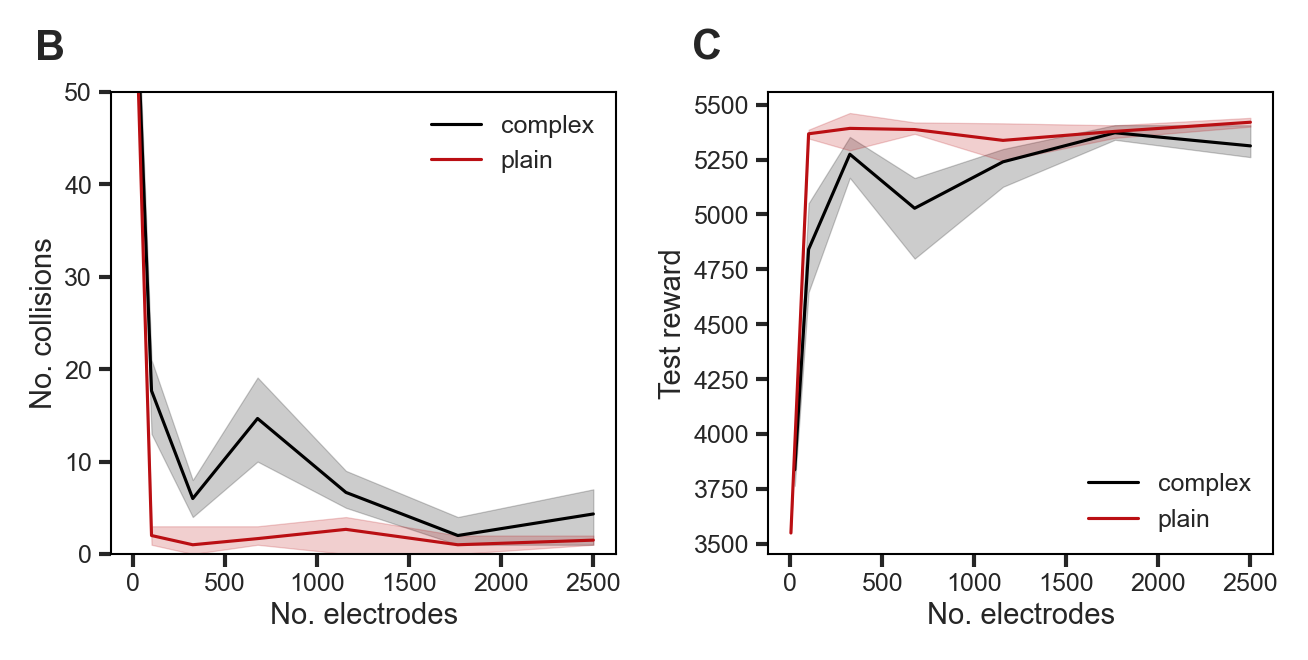

In [10]:
# Select the data to visualize
data = test_results

# Only include first three random initialization seeds. 
# (These are the training instances for which all conditions were finished.)
data = data.loc[data.seed.isin([0,1,2])].copy()

# Read all experimental parameters (independent variables)
for y in indep_vars:
    data[y] = results['train_specs'].loc[data.index,y].values
data['Electrodes'] = data['phosphene_resolution'] **2 # Electrode count instead of resolution .. x ..

# Select the outcome performance metrics (dependent variables)
dep_vars =  ['box_collisions', 'cumulative_reward'] # 'endless_loops', 'step_count',
labels = ['No. collisions', 'Test reward']

# Set visualization parameters
n_figs = len(dep_vars)
visualization.set_figurestyle(colors={'black':'k', 'red':'#ba0f13'})
fig, axs = plt.subplots(1,n_figs, figsize=(2.5*n_figs, 2), dpi=300)
fig.subplots_adjust(wspace=0.3)

# Create lineplots
for i,y in enumerate(dep_vars):
    sns.lineplot(data=data, x='Electrodes', y=y, ax=axs[i], hue='complexity') #, err_style='bars')
    # sns.scatterplot(data=data, x='Electrodes', y=y, ax=axs[i], hue='complexity') #, err_style='bars')
    # axs[i].get_legend().set_title('Env. Complexity')
    axs[0].set_ylim((0,50))
    axs[i].get_legend().set_title('')
    visualization.add_panel_index(axs[i],['B','C'][i])
    axs[i].set(xlabel = 'No. electrodes',
               ylabel = labels[i])

# # Save figure
# fig.savefig('Figures/resolution_vs_performance_bc.png',bbox_inches='tight')

# # Save data (to easily redo visualization later)
# data.to_csv('Figures/resolutions_perf_RL.csv')


Text(0.5, 0, 'No. electrodes')

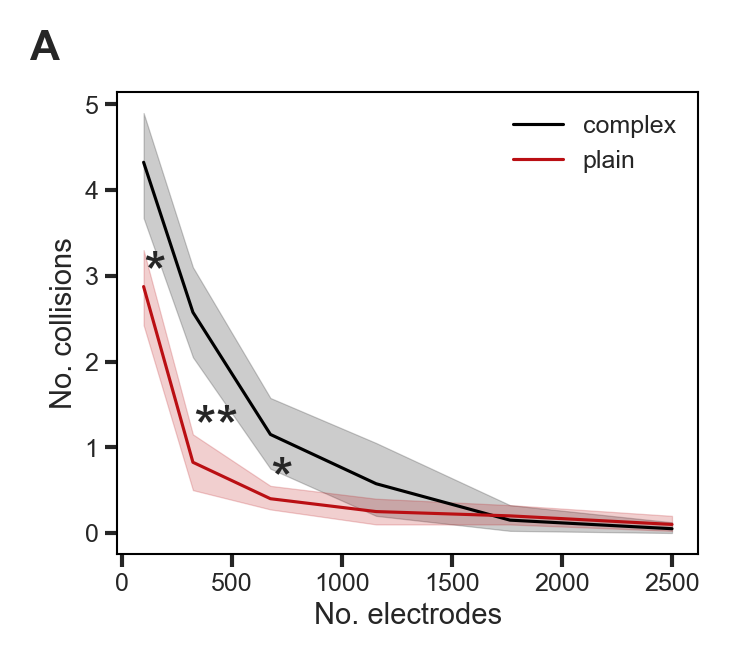

In [11]:
#### Plot baseline study (as comparison; see mobility paper https://doi.org/10.1167/jov.22.2.1)

# Create subplot axis
fig, axs = plt.subplots(1,1,figsize=(2.5*1,2), dpi=300)
axs = [axs]

# Read the data
wf1_data = pd.read_csv('Figures/WF1_data.csv')
data = wf1_data.loc[wf1_data.model_type=='Canny']
data.loc[:,'condition_2'] = data.condition_2.replace({'simple':'plain'})

# Plot lineplots
sns.lineplot(data=data, x='resolution', y='n_collisions', hue='condition_2', ax=axs[0])
axs[0].get_legend().set_title('')

# Add significance stars
stars_x = [10*10, 18*18, 26*26]
stars_y = [2.8, 1.0, 0.4]
stars_txt = ['*','**', '*'] 
for x,y,txt in zip(stars_x,stars_y,stars_txt):
    axs[0].text(x,y,txt,size=14)

# Add panel index 
visualization.add_panel_index(axs[0],'A')

# Change axis labels
axs[0].set_ylabel('No. collisions')
axs[0].set_xlabel('No. electrodes')

# # Save figure
# fig.savefig('Figures/resolution_vs_performance_ab.png',bbox_inches='tight')

## Results Experiment 2

### Get best models 

In [14]:
results = get_results(directory=savedirs['exp_2'], copy_columns= indep_vars)
best_models, val_stats = get_best_models(results['train_stats_stacked'], smooth_episodes=10)
best_models[['test_file', 'checkpoint_file']] = get_test_files(best_models)
test_results = read_test_results(best_models, savedirs['exp_2'], indep_vars=indep_vars)

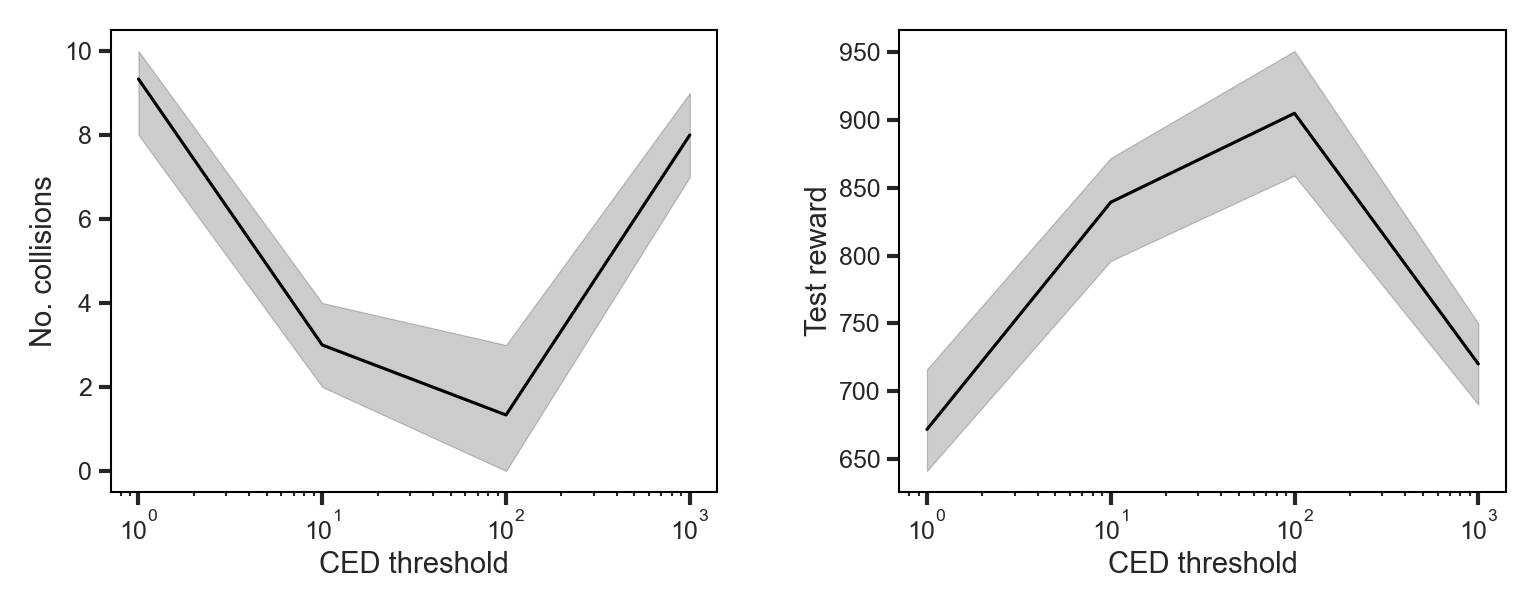

In [15]:
# Select which data to plot
data = test_results

# Select dependent variables and experimental paramerters
endpoints = ['box_collisions', 'cumulative_reward']
ylabels = ['No. collisions', 'Test reward']
xlabel = 'CED threshold'

# Create subplot axes
visualization.set_figurestyle()
fig, axs = plt.subplots(1,2, figsize=(6,2),dpi=300)
fig.subplots_adjust( wspace=0.3)

# Plot lineplots
for i, y in enumerate(endpoints):
    sns.lineplot(data=data, x='edge_threshold', y=y, ax=axs[i], color='k')
    axs[i].set(xscale='log',
        xlabel = xlabel,
        ylabel = ylabels[i])
plt.show()

# # Save figure
# fig.savefig("figures/exp2_results.png", bbox_inches='tight')

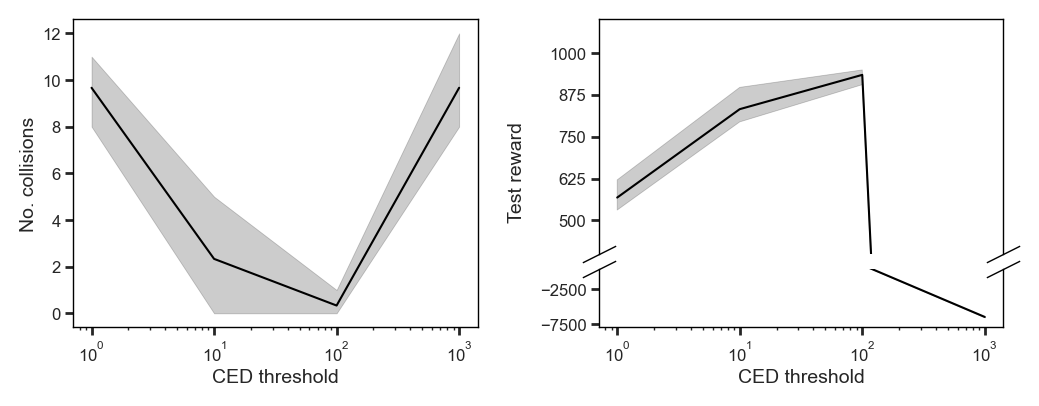

In [411]:
import visualization
import importlib
importlib.reload(visualization)
visualization.set_figurestyle()

endpoints = ['box_collisions', 'cumulative_reward']
ylabels = ['No. collisions', 'Test reward']
xlabel = 'CED threshold'

fig = plt.figure(figsize=(6,2),dpi=200)
gs = matplotlib.gridspec.GridSpec(2, 2,height_ratios=[4,1], hspace=0.1, wspace=0.3, figure=fig)  

ax0 = plt.subplot(gs[:,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,1])

## Axs 0 (left panel)
sns.lineplot(data=final_tests, x='edge_threshold', y=endpoints[0], ax=ax0, color='k')
ax0.set(xscale='log',
        xlabel = xlabel,
        ylabel = ylabels[0])


## Axs 1+2 (right panel)
sns.lineplot(data=final_tests, x='edge_threshold', y=endpoints[1], ax=ax1, color='k')
sns.lineplot(data=final_tests, x='edge_threshold', y=endpoints[1], ax=ax2, color='k')


ax2.set(ylim=[-8000, 400],
        xscale = 'log',
        ylabel= '',
        xlabel=xlabel,
        yticks = [-2500, -7500]) 

ax1.set(ylim=[400, 1100],
        xscale = 'log',
        xlabel='',
        ylabel=ylabels[1],
        yticks= np.linspace(500,1000,5)) 
ax1.yaxis.set_label_coords(-.18, 0.35)

# Remove spines and ticks
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)

# Add break lines
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=0.5, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# fig.savefig("figures/exp2_results.png", bbox_inches='tight')

#### Configure test setup

In [34]:
import sys
import torch
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# # local files
sys.path.insert(0, '../')
import model
import imgproc
import pyClient 
import testing
import utils

save_directory = savedirs['exp_2']
results = get_results(directory=savedirs['exp_2'], copy_columns= indep_vars)
train_specs = results['train_specs']
train_specs = train_specs.fillna(np.nan).replace([np.nan], [None])

In [99]:


# Load previous test results
if os.path.exists(os.path.join(save_directory,'_test_results.csv')):
    test_results = pd.read_csv(os.path.join(save_directory,'_test_results.csv')).fillna(np.nan).replace([np.nan], [None]).set_index('model_name')
    todo = train_specs.loc[~train_specs.index.isin(test_results.index)]
    print('found previous test results (appending new ones)')
else: 
    test_results = None
    todo = train_specs

#### Can be removed (assuming that all models are finished training)
todo = todo.loc[todo.status == 'finished'].copy()

# Load all checkpoints per model
checkpoints = dict()
for model_name in todo.index:
    checkpoints[model_name] = sorted(glob(f'{save_directory}/{model_name}_*.pth'))

test_cfg = {'savedir'       : save_directory,
            'reset_end_is_0': False,
            'reset_end_is_1': False,
            'reset_end_is_2': False,
            'reset_end_is_3': True,
            'device'        : 'cpu',
            'ip'            : '127.0.0.1',
            'port'          : 13000,}

print('todo:\n' + '\n'.join(todo.index))

todo:
exp2-aug11_comp_plain-seed_0-mode_edge-detection-phos_34-edge_1
exp2-aug11_comp_plain-seed_0-mode_edge-detection-phos_34-edge_10
exp2-aug11_comp_plain-seed_0-mode_edge-detection-phos_34-edge_100
exp2-aug11_comp_plain-seed_0-mode_edge-detection-phos_34-edge_1000
exp2-aug11_comp_plain-seed_1-mode_edge-detection-phos_34-edge_1
exp2-aug11_comp_plain-seed_1-mode_edge-detection-phos_34-edge_10
exp2-aug11_comp_plain-seed_1-mode_edge-detection-phos_34-edge_100


In [100]:
test(agent, environment, img_processing, cfg, store_replay=False, store_Q_predictions=False)

#### Test run

In [107]:
import sys
sys.path.append('./..')
import imgproc
import utils 
import pyClient
import model
import torch



test_data = []
environment_connected = False
for _ , cfg in todo.iterrows():
    current_model = cfg.name

    print(current_model)
    # Additional training settings (inferred from specified settings)
    cfg.update(test_cfg)
    cfg['training_condition'] = {'plain': 0, 'complex': 1}[cfg['complexity']]
    cfg['model_path']         = checkpoints[current_model][-1] #os.path.join(cfg.savedir,'{}.pth'.format(current_model)) 
    cfg['model_name']         = current_model

    # Initialize model components
    img_processing = imgproc.ImageProcessor(**cfg)
    environment =  pyClient.Environment(**cfg) if not environment_connected else environment # Only initialized on first run

    agent = model.DoubleDQNAgent(**cfg)
    agent.policy_net.load_state_dict(torch.load(cfg['model_path'] ,map_location=cfg['device']))
    agent.policy_net.eval()
    
    
    # # Training
    assert environment.client is not None, "Error: could not connect to env. Make sure to start Unity server first!"
    environment_connected = True

    results = test(agent, environment, img_processing, cfg, store_replay=True, store_Q_predictions=True)
    test_data.append({**cfg,**results})


    # write replay memory to video
    # videopath = os.path.join(OUT_PATH,'{}.avi'.format(current_model))
    # utils.save_replay(agent.memory.memory, videopath,(cfg['imsize'], cfg['imsize']))
# data = pd.DataFrame(test_data)
# data.to_csv(os.path.join(OUT_PATH,'_test_results.csv'), index=False)

if test_results is None:
    test_results = pd.DataFrame(test_data).set_index('model_name')
else:
    test_results = pd.concat([test_results,pd.DataFrame(test_data).set_index('model_name')])
# test_results.to_csv(os.path.join(OUT_PATH,'_test_results.csv'))

exp2-aug11_comp_plain-seed_0-mode_edge-detection-phos_34-edge_1
exp2-aug11_comp_plain-seed_0-mode_edge-detection-phos_34-edge_10
exp2-aug11_comp_plain-seed_0-mode_edge-detection-phos_34-edge_100
exp2-aug11_comp_plain-seed_0-mode_edge-detection-phos_34-edge_1000
exp2-aug11_comp_plain-seed_1-mode_edge-detection-phos_34-edge_1
exp2-aug11_comp_plain-seed_1-mode_edge-detection-phos_34-edge_10
exp2-aug11_comp_plain-seed_1-mode_edge-detection-phos_34-edge_100


In [108]:
test_results = pd.DataFrame(test_data).set_index('model_name')
test_results.to_csv(os.path.join(save_directory,'_test_results.csv'))

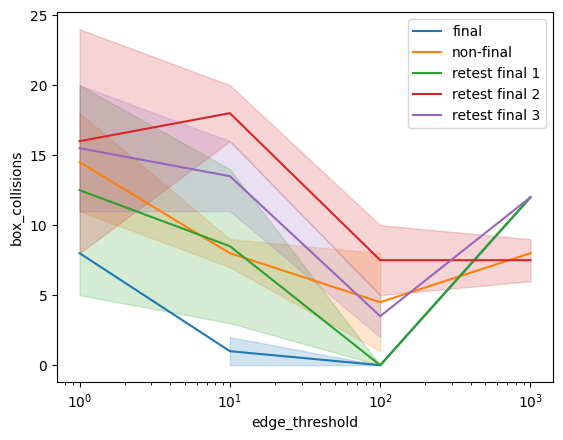

In [113]:
# From test results during training (final model, different machine)
results = get_results(directory=savedirs['exp_2'], copy_columns= indep_vars)
data = results['final_tests']
data['edge_threshold'] = results['train_specs'].loc[data.model_name, 'edge_threshold'].values
sns.lineplot(data=data, x='edge_threshold', y='box_collisions', label='final')

# Test results of saved model (tested on current machine. Is not the final model but the 'best' model) 
test_results_non_final = pd.read_csv(os.path.join(save_directory, '_test_results_non-final.csv'))
sns.lineplot(data=test_results_non_final, x='edge_threshold', y='box_collisions', label='non-final')

# Test results of saved model (tested on current machine. Final saved model) 
test_results_1 = pd.read_csv(os.path.join(save_directory, '_test_results_1.csv'))
sns.lineplot(data=test_results_1, x='edge_threshold', y='box_collisions', label='retest final 1')

# Test results of saved model (tested on current machine. Final saved model) 
test_results_2 = pd.read_csv(os.path.join(save_directory, '_test_results_2.csv'))
sns.lineplot(data=test_results_2, x='edge_threshold', y='box_collisions', label='retest final 2')

# Test results of saved model (tested on current machine. Final saved model) 
test_results_3 = pd.read_csv(os.path.join(save_directory, '_test_results_3.csv'))
sns.lineplot(data=test_results, x='edge_threshold', y='box_collisions', label='retest final 3')


plt.xscale('log')

<Axes: xlabel='episode', ylabel='reward_avg_10'>

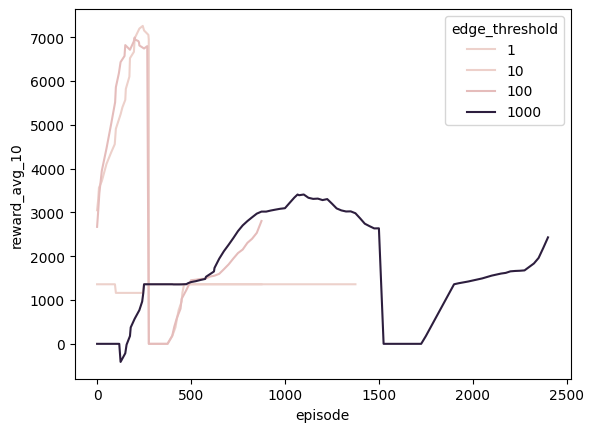

In [32]:
results = get_results(directory=savedirs['exp_2'], copy_columns= indep_vars)
data = results['train_stats_stacked']
data = data.loc[data.validation == 1].copy()
data['reward_avg_5'] = data.groupby('model_name').reward.rolling(5,center=False).mean().values
data['reward_avg_10'] = data.groupby('model_name').reward.rolling(10,center=False).mean().values
# data = data.set_index('model_name')

mask = (data.seed==0) & (data.complexity=='plain')
sns.lineplot(data=data.fillna(0).loc[mask],
             hue='edge_threshold', y='reward_avg_10', x='episode')

# Baseline model

#### Get best model
For the trained models, get the chechpoint at which it performed best over the course of optimization.

In [18]:
results = get_results(directory=savedirs['exp_0'], copy_columns= indep_vars)
train_specs = results['train_specs']
best_models, val_stats = get_best_models(results['train_stats_stacked'], smooth_episodes=2)
best_models[['test_file', 'checkpoint_file']] = get_test_files(best_models)
test_results = read_test_results(best_models, savedirs['exp_0'], indep_vars=indep_vars)

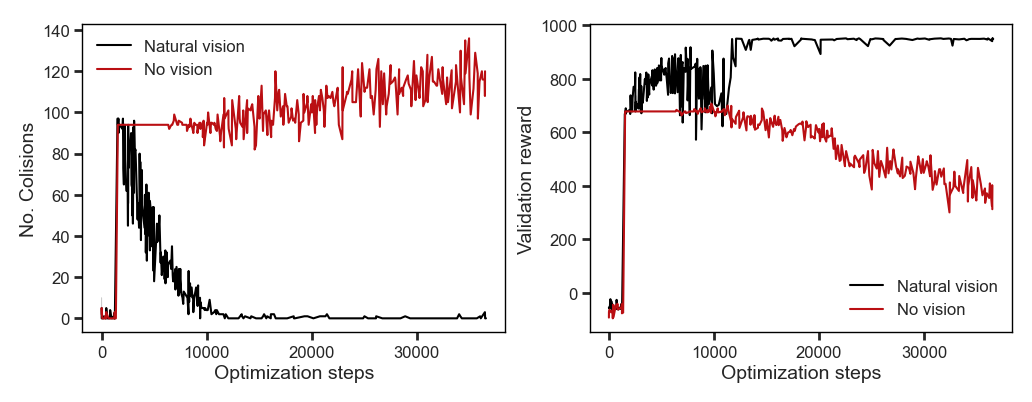

In [22]:
# Select which data to plot
data = val_stats.copy()

# Collect data of the experimental conditions (independent variables)
indep_vars_ = indep_vars + ['mode']
for y in indep_vars_:
    data[y] = train_specs.loc[data.model_name, y].values
data['mode'] = data['mode'].replace({'camera-vision': 'Natural vision',
                                     'no-vision': 'No vision'})
xlabel =  'Optimization steps'

# Collect the experimental outcomes (dependent variables)
data['validation_reward'] = data.reward / 10 # Based on cumulative reward of 10 test runs, so dived by 10
endpoints = ['box_collisions', 'validation_reward']
ylabels = ['No. Colisions', 'Validation reward']


# Plot figures
visualization.set_figurestyle(colors = {'black':'k', 'red': '#ba0f13'})
fig, axs = plt.subplots(1,2, figsize=(6,2), dpi=200)
for i, y in enumerate(endpoints):
    sns.lineplot(data=data.loc[data[y].notnull()], y=y, x='optimization_steps', hue='mode', ax=axs[i])
    axs[i].set(ylabel = ylabels[i],
               xlabel = xlabel)
    axs[i].legend().set_title = ''

# fig.savefig('figures/exp0_baseline.png', bbox_inches='tight')

## Example run

#### Perform a test run in Unity

In [24]:
# Load the results
save_directory = savedirs['exp_0']
results = get_results(directory=savedirs['exp_0'], copy_columns= indep_vars)
train_specs = results['train_specs']
train_specs = train_specs.fillna(np.nan).replace([np.nan], [None])

In [25]:
# Load all checkpoints per model
checkpoints = dict()
finished = train_specs.loc[train_specs.status == 'finished']
for model_name in finished.index:
    checkpoints[model_name] = sorted(glob(f'{save_directory}/{model_name}_*.pth'))

test_cfg = {'savedir'       : save_directory,
            'reset_end_is_0': False,
            'reset_end_is_1': False,
            'reset_end_is_2': False,
            'reset_end_is_3': True,
            'device'        : 'cpu',
            'ip'            : '127.0.0.1',
            'port'          : 13000,}

print('finished models:\n' + '\n'.join(finished.index))

finished models:
exp0-nov2023_comp_plain-seed_0-mode_camera-vision
exp0-nov2023_comp_complex-seed_0-mode_camera-vision
exp0-nov2023_comp_plain-seed_0-mode_no-vision
exp0-nov2023_comp_plain-seed_1-mode_camera-vision
exp0-nov2023_comp_complex-seed_1-mode_camera-vision
exp0-nov2023_comp_plain-seed_1-mode_no-vision
exp0-nov2023_comp_plain-seed_2-mode_camera-vision
exp0-nov2023_comp_complex-seed_2-mode_camera-vision
exp0-nov2023_comp_plain-seed_2-mode_no-vision


In [26]:
# Load the models 
import sys
sys.path.append('./..')
import imgproc
import utils 
import pyClient
import model
import torch
import cv2
from testing import test

cfg = finished.iloc[0].copy()
# cfg = finished.iloc[2].copy()
cfg['phosphene_resolution'] = None

current_model = cfg.name

# Additional training settings (inferred from specified settings)
cfg.update(test_cfg)
cfg['training_condition'] = {'plain': 0, 'complex': 1}[cfg['complexity']]
cfg['model_path']         = checkpoints[current_model][-1] #os.path.join(cfg.savedir,'{}.pth'.format(current_model)) 
cfg['model_name']         = current_model

# Initialize model components
img_processing = imgproc.ImageProcessor(**cfg)
environment =  pyClient.Environment(**cfg) 

agent = model.DoubleDQNAgent(**cfg)
agent.policy_net.load_state_dict(torch.load(cfg['model_path'] ,map_location=cfg['device']))
agent.policy_net.eval()

DQN(
  (conv1): Conv2d(4, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Linear(in_features=5408, out_features=3, bias=True)
)

In [126]:
# Get the test results
with torch.no_grad():
    testing_results = test(agent, environment, img_processing, cfg, store_replay=True, store_Q_predictions=True)

In [130]:
q_values = agent.Q_predictions
q0, q1, q2 = torch.stack(q_values).squeeze().split(1,dim=1)


# Infer x and y locations based on actions
actions = []
x_pos, y_pos = [], []
states = []
x = 0
y = 1
for i, (s_i, a, s_next, r) in enumerate(agent.memory.memory):
    action = a.item()
    actions.append(action)
    if a == 0:
        x += 1
    elif a == 1:
        y = min(2,y+1)
    else:
        y = max(0,y-1)
    states.append(s_i.numpy().squeeze()[-1])
    y_pos.append(y)
    x_pos.append(x)
x_pos = np.array(x_pos)#*0.95
y_pos = np.array(y_pos)#*0.5

In [131]:
example_run = pd.DataFrame({'model_name': [model_name,] * len(actions),
                          'actions': actions,
                          'x_pos': x_pos,
                          'y_pos': y_pos,
                          'q0': q0.squeeze(),
                          'q1': q1.squeeze(),
                          'q2': q2.squeeze(),})

# # Save results
# example_run.to_csv(f'Figures/example_run_{model_name}.csv')

#### Visualize the test run

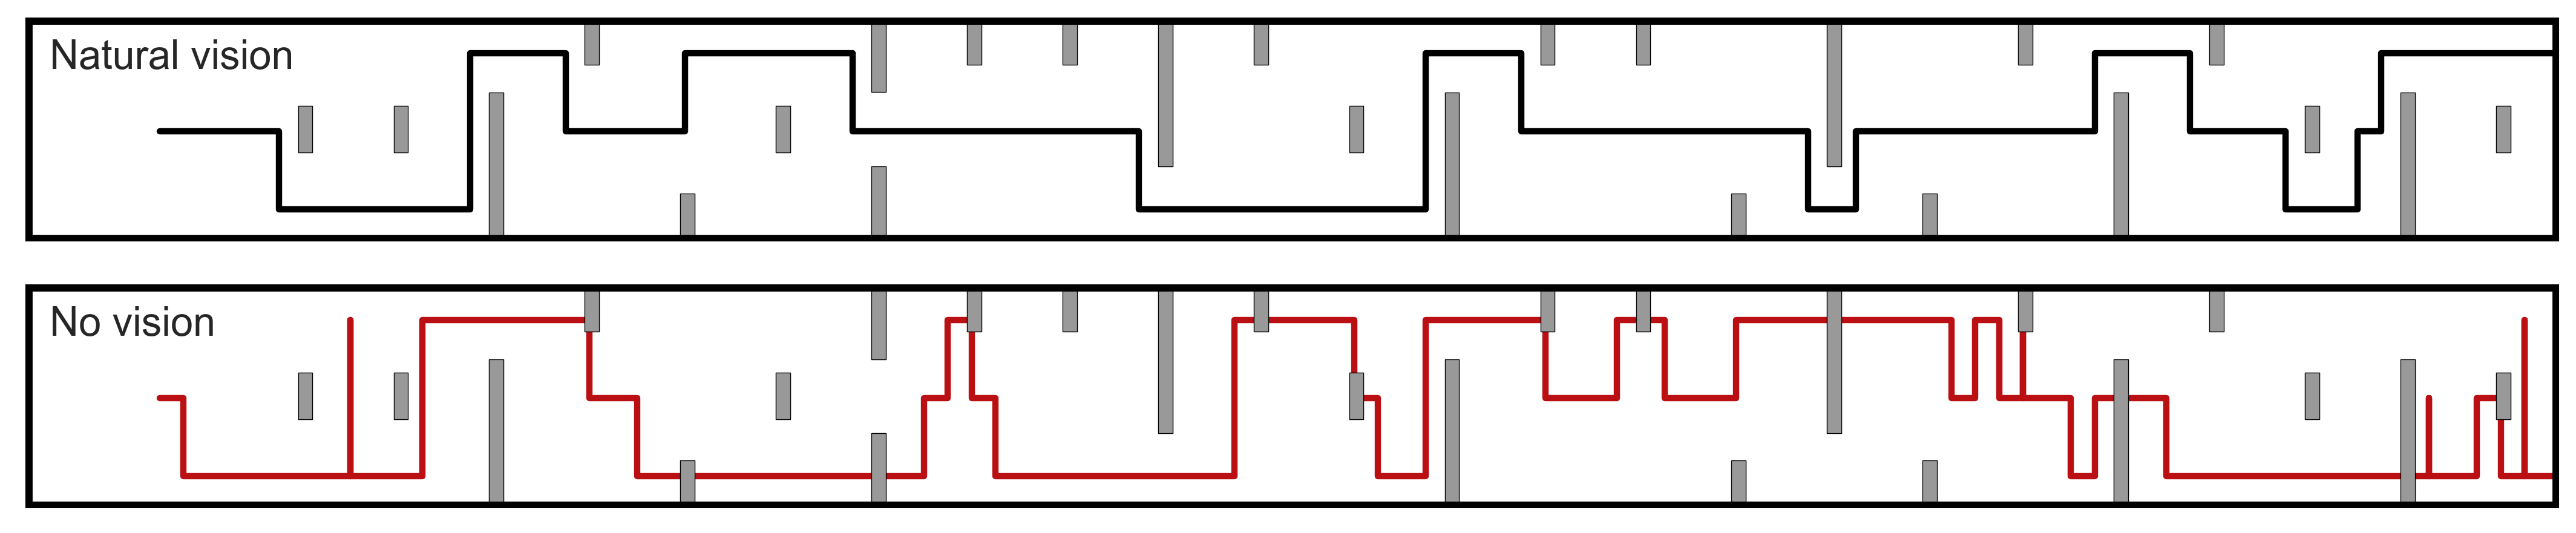

In [29]:
from env_params import get_hallway_layouts
from matplotlib.patches import Rectangle
import visualization

# Plot test hallway
fig, axs = plt.subplots(2,1, figsize=(18,3.5),dpi=300)
hallways = get_hallway_layouts()


n = 200

# Plot trajectory
colors = ['k','#ba0f13']

for i, model_name in enumerate(['exp0-nov2023_comp_plain-seed_0-mode_camera-vision',
                               'exp0-nov2023_comp_plain-seed_0-mode_no-vision']):
    data = pd.read_csv(f'Figures/example_run_{model_name}.csv')
    axs[i].plot((data.x_pos[:n]+4.6)*.5,
        data.y_pos[:n]+.4,
        linewidth=2.5, color= colors[i])

    visualization.plot_hallway(hallways['test_hallway'], ax=axs[i])
    rect = Rectangle((0,0),53, 2.85, facecolor='none', edgecolor='k', linewidth=5, zorder=10)
    axs[i].add_patch(rect)
    axs[i].text(0.5,2.2,['Natural vision', 'No vision'][i], size=16, )#weight="bold")

    axs[i].set_xlim([0,53])

# # Save figure
# fig.savefig('figures/test_trajectory.png', bbox_inches='tight')

## Perturbation Analysis

#### Setup test config

In [30]:
# Load training specifications
save_directory = savedirs['exp_0']
results = get_results(directory=savedirs['exp_0'], copy_columns= indep_vars)
train_specs = results['train_specs']
train_specs = train_specs.fillna(np.nan).replace([np.nan], [None])

In [31]:
# Load all checkpoints per model
checkpoints = dict()
finished = train_specs.loc[train_specs.status == 'finished']
for model_name in finished.index:
    checkpoints[model_name] = sorted(glob(f'{save_directory}/{model_name}_*.pth'))

test_cfg = {'savedir'       : save_directory,
            'reset_end_is_0': False,
            'reset_end_is_1': False,
            'reset_end_is_2': False,
            'reset_end_is_3': True,
            'device'        : 'cpu',
            'ip'            : '127.0.0.1',
            'port'          : 13000,}

print('finished models:\n' + '\n'.join(finished.index))

finished models:
exp0-nov2023_comp_plain-seed_0-mode_camera-vision
exp0-nov2023_comp_complex-seed_0-mode_camera-vision
exp0-nov2023_comp_plain-seed_0-mode_no-vision
exp0-nov2023_comp_plain-seed_1-mode_camera-vision
exp0-nov2023_comp_complex-seed_1-mode_camera-vision
exp0-nov2023_comp_plain-seed_1-mode_no-vision
exp0-nov2023_comp_plain-seed_2-mode_camera-vision
exp0-nov2023_comp_complex-seed_2-mode_camera-vision
exp0-nov2023_comp_plain-seed_2-mode_no-vision


#### Load model parameters

In [35]:
import sys
sys.path.append('./..')
import imgproc
import utils 
import pyClient
import model
import torch
import cv2
import pickle

cfg = finished.iloc[0].copy()

current_model = cfg.name

# Additional training settings (inferred from specified settings)
cfg.update(test_cfg)
cfg['training_condition'] = {'plain': 0, 'complex': 1}[cfg['complexity']]
cfg['model_path']         = checkpoints[current_model][-1] #os.path.join(cfg.savedir,'{}.pth'.format(current_model)) 
cfg['model_name']         = current_model

# Initialize model components
img_processing = imgproc.ImageProcessor(**cfg)
environment =  pyClient.Environment(**cfg) 

# Load model parameters
agent = model.DoubleDQNAgent(**cfg)
agent.policy_net.load_state_dict(torch.load(cfg['model_path'] ,map_location=cfg['device']))
agent.policy_net.eval()

DQN(
  (conv1): Conv2d(4, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Linear(in_features=5408, out_features=3, bias=True)
)

#### Obtain the state to be evaluated

In [259]:
# # Reset environment at start of episode
# _, _, _ = environment.reset(cfg['training_condition']+2)

# # Create an empty frame stack and fill it with frames
# frame_stack = imgproc.FrameStack(stack_size=cfg['stack_size'] )
# for _ in range(cfg['stack_size'] ):
#     _, _, frame_raw = environment.step(0)
#     frame = img_processing(frame_raw).to(agent.device)
#     state = frame_stack.update_with(frame)


# plt.imshow(frame_raw['colors'])

In [84]:
## Perform additional steps
# _, _, frame_raw = environment.step(0)
# frame = img_processing(frame_raw).to(agent.device)
# state = frame_stack.update_with(frame)


In [199]:
## Save state and last frame
# with open('figures/example_frame.pickle', 'wb') as handle:
#     pickle.dump(frame_raw, handle, protocol=pickle.HIGHEST_PROTOCOL)
# torch.save(state, "figures/example_state.pt")

In [256]:
# Load state and last frame
with open('figures/example_frame.pickle', 'rb') as handle:
    frame_raw = pickle.load(handle)

state = torch.load("figures/example_state.pt")

#### Perform systematic perturbation

In [135]:
x = 0 
y = 0

def perturbator(simulator, pert_type="black"):
    def wrapper(frame):
        SIZE = 30
        
        # Perturb
        frame_ = frame.copy()

        msk = np.ones((128,128))
        msk = cv2.circle(msk, (x,y), SIZE, 0, -1) 

        # Default: draw a black circle
        frame_ = frame * msk
            
        if pert_type == "loc_avg":
            local_avg = np.mean(frame[(1-msk).astype(bool)]) # calc local avg
            frame_ += (1-msk) * local_avg # fill circle with local avg
        elif pert_type == "gray":
            frame_ += (1-msk) * 155
            
        # simulate
        return simulator(frame_.astype('uint8'))
    return wrapper

# Create image processing module from config
perturbed_proc = imgproc.ImageProcessor(**cfg)

# If current condition configures no SPV add identity func as simulator
if cfg.phosphene_resolution is None:
    perturbed_proc.simulator = lambda x:x

# Wrap the phosphene simulator with the image perturbation
perturbed_proc.simulator = perturbator(perturbed_proc.simulator, pert_type="loc_avg")



In [136]:
# Save perturbation data 
pert_data = pd.DataFrame()

# Obtain baseline results first
with torch.no_grad():
    base_q = agent.policy_net(state).squeeze().numpy()

# Perform perturbation
with torch.no_grad():
    state_ = state.clone()

    # For each coordinate in a grid 
    n_per_axis = 64 # 32 x 32 grid points
    interval, step = np.linspace(0,128,n_per_axis, endpoint=False, retstep=True)
    interval = (interval+.5*step).astype(int)
    i = 0
    for x in interval:
        for y in interval:

            # perform_perturbation and calculate Q-values
            state_[0,-1] = perturbed_proc(frame_raw)
            q_values = agent.policy_net(state_).squeeze().numpy()
            q_diff = (q_values - base_q) / base_q

            # Store output data
            pert_data.loc[i, ['q0', 'q1', 'q2']] = q_values
            pert_data.loc[i, ['q_diff0', 'q_diff1', 'q_diff2']] = q_diff
            pert_data.loc[i, ['mean_abs_diff']] = np.abs(q_diff).mean()
            pert_data.loc[i, ['x', 'y']] = x, y
            
            i += 1

In [137]:
pert_heatmap = np.zeros((128,128))
q0_heatmap = np.zeros((128,128))
q1_heatmap = np.zeros((128,128))
q2_heatmap = np.zeros((128,128))
for i, row in pert_data.iterrows():

    SIZE = 10
    
    y_min = np.max([0, row.y - SIZE]).astype(int)
    x_min = np.max([0, row.x - SIZE]).astype(int)
    y_max = np.min([127, row.y + SIZE]).astype(int)
    x_max = np.min([127, row.x + SIZE]).astype(int)
    
    pert_heatmap[y_min:y_max, x_min:x_max] += row.mean_abs_diff
    q0_heatmap[y_min:y_max, x_min:x_max] += row.q_diff0
    q1_heatmap[y_min:y_max, x_min:x_max] += row.q_diff1
    q2_heatmap[y_min:y_max, x_min:x_max] += row.q_diff2
    # print(f"{x_min}:{x_max}, {y_min}:{y_max} {row.mean_abs_diff}")

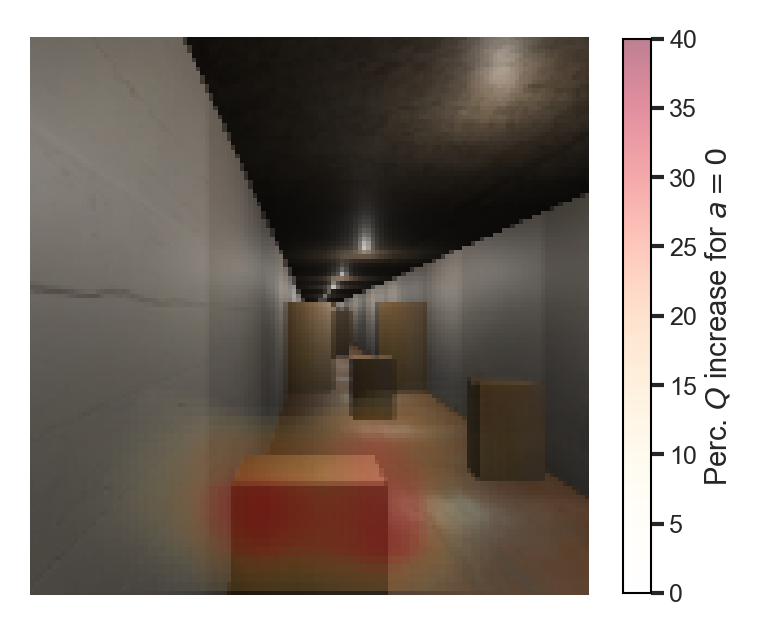

In [200]:
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

# Choose colormap
# cmap = pl.cm.coolwarm

# # Diverging
# cmap = pl.cm.RdBu_r

# # Set alpha
# my_cmap = cmap(np.arange(cmap.N))
# my_cmap[:,-1] = np.abs(np.linspace(-.5, .5, cmap.N))
# my_cmap = ListedColormap(my_cmap)

# Diverging
cmap = pl.cm.YlOrRd

# Set alpha
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 0.50, cmap.N)
my_cmap = ListedColormap(my_cmap)

visualization.set_figurestyle()
fig = plt.figure(figsize=(3,3), dpi=300)
plt.imshow(frame_raw['colors'], alpha=1.)
plt.imshow(q0_heatmap.clip(0,np.inf), cmap=my_cmap, vmin=0, vmax=40)






plt.colorbar(shrink=0.8, label="Perc. $Q$ increase for $a=0$")
plt.axis('off')
fig.savefig("figures/positive_pert_a0.png", bbox_inches='tight')

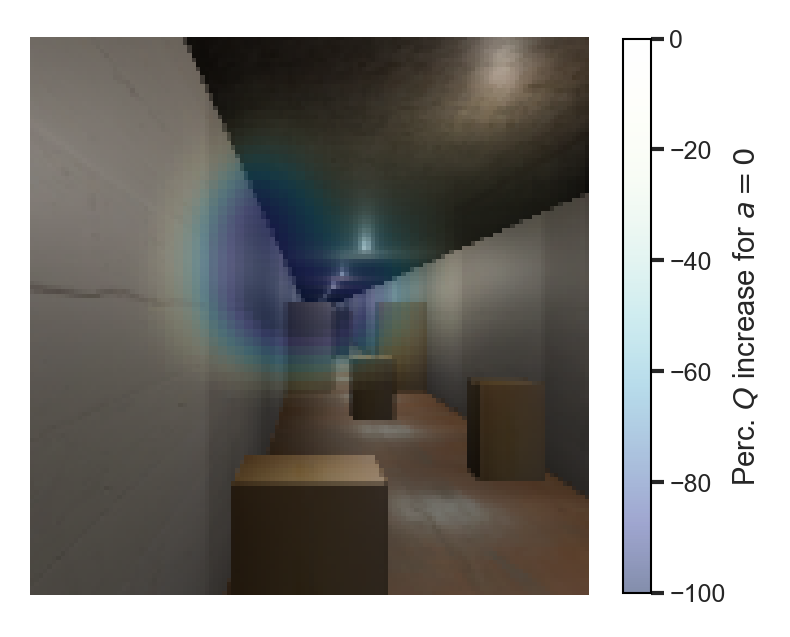

In [209]:
visualization.set_figurestyle()

# Diverging
cmap = pl.cm.YlGnBu_r

# Set alpha
# Set alpha
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0.5, 0, cmap.N)
my_cmap = ListedColormap(my_cmap)

fig = plt.figure(figsize=(3,3), dpi=300)
plt.imshow(frame_raw['colors'], alpha=1.)
plt.imshow(q0_heatmap.clip(-np.inf,0), cmap=my_cmap, vmin=-100, vmax=0)
plt.colorbar(shrink=0.8, label="Perc. $Q$ increase for $a=0$")
plt.axis('off')

fig.savefig("figures/negative_pert_a0.png", bbox_inches='tight')

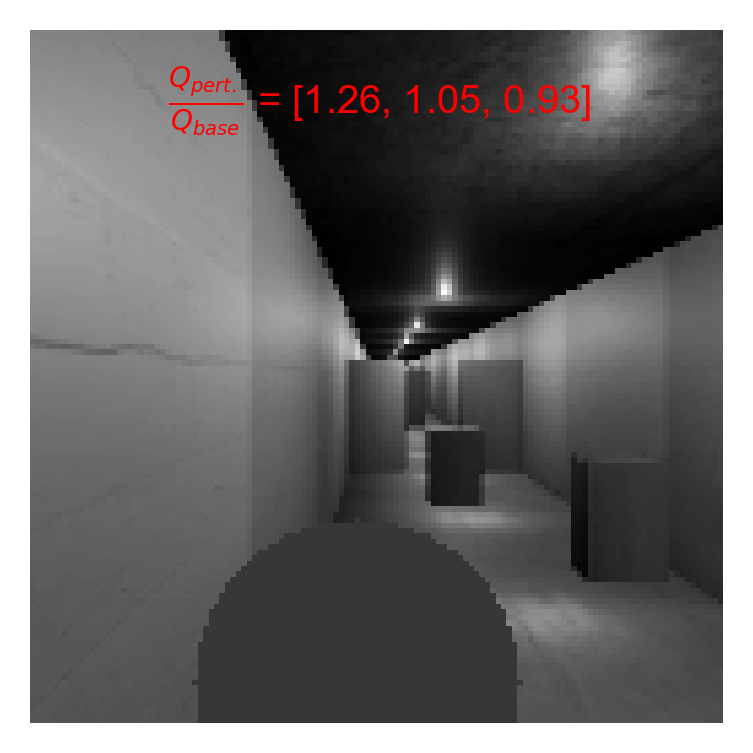

In [252]:
x= 60
y= 120


fig = plt.figure(figsize=(3,3), dpi=300)
state_[0,-1] = perturbed_proc(frame_raw)
plt.imshow(state_[0,-1].squeeze(), cmap='gray')

with torch.no_grad():
    base_q = agent.policy_net(state).squeeze().numpy()
    pert_q = agent.policy_net(state_).squeeze().numpy()

plt.axis('off')

# plt.text(3,8,"$Q_{base}$ = "+"[{:.1f}, {:.1f}, {:.1f}]".format(*base_q), color="r")
# plt.text(3,20,"$Q_{pert.}$ = "+"[{:.1f}, {:.1f}, {:.1f}]".format(*pert_q), color="r")
plt.text(25,15,r"$\frac{Q_{pert.}}{Q_{base}}$ = "+"[{:.2f}, {:.2f}, {:.2f}]".format(*(pert_q/base_q)), color="r")
fig.savefig("figures/pert_example_pos.png", bbox_inches='tight')

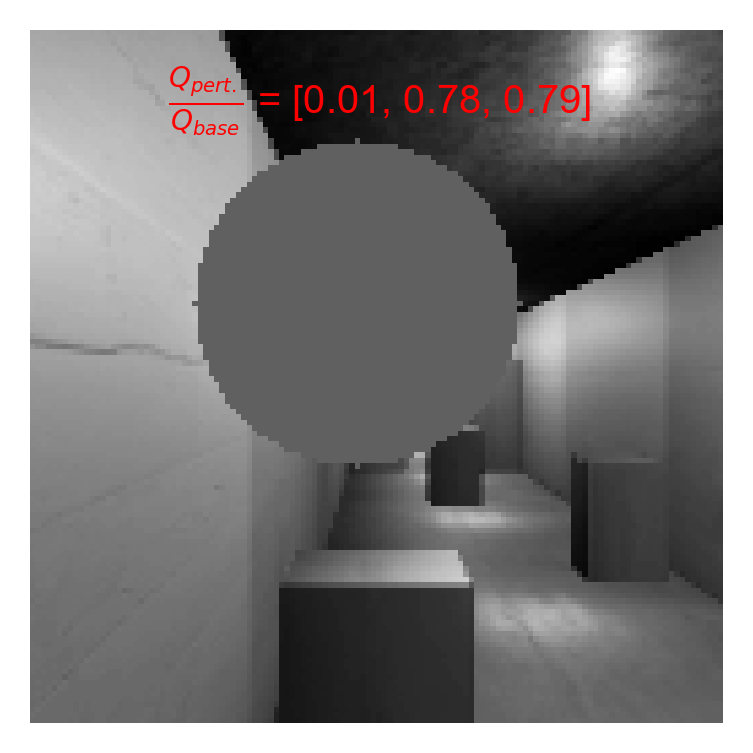

In [251]:
x= 60
y= 50


fig = plt.figure(figsize=(3,3), dpi=300)
state_[0,-1] = perturbed_proc(frame_raw)
plt.imshow(state_[0,-1].squeeze(), cmap='gray')

with torch.no_grad():
    base_q = agent.policy_net(state).squeeze().numpy()
    pert_q = agent.policy_net(state_).squeeze().numpy()

plt.axis('off')

# plt.text(3,8,"$Q_{base}$ = "+"[{:.1f}, {:.1f}, {:.1f}]".format(*base_q), color="r")
# plt.text(3,20,"$Q_{pert.}$ = "+"[{:.1f}, {:.1f}, {:.1f}]".format(*pert_q), color="r")
plt.text(25,15,r"$\frac{Q_{pert.}}{Q_{base}}$ = "+"[{:.2f}, {:.2f}, {:.2f}]".format(*(pert_q/base_q)), color="r")
fig.savefig("figures/pert_example_neg.png", bbox_inches='tight')

#### Additional image processing examples

In [3]:
import sys
sys.path.append('./..')
import imgproc
import utils 
import pyClient
import model
import torch
import cv2
from testing import test
import pickle

# Load state and last frame
with open('figures/example_frame.pickle', 'rb') as handle:
    frame_raw = pickle.load(handle)

state = torch.load("figures/example_state.pt")

In [11]:
save_directory = savedirs['exp_0']
results = get_results(directory=savedirs['exp_0'], copy_columns= indep_vars)
train_specs = results['train_specs']
train_specs = train_specs.fillna(np.nan).replace([np.nan], [None])
test_cfg = {'savedir'       : save_directory,
            'reset_end_is_0': False,
            'reset_end_is_1': False,
            'reset_end_is_2': False,
            'reset_end_is_3': True,
            'device'        : 'cpu',
            'ip'            : '127.0.0.1',
            'port'          : 13000,}

cfg = train_specs.iloc[0]


cfg_ = cfg.copy()
cfg_["mode"] = 'edge-detection'
cfg_["phosphene_resolution"] = None

edges = [frame_raw['colors']]
for threshold in [5, 100, 500]:
    cfg_["edge_threshold"] = threshold

    # Create image processing module from config
    proc = imgproc.ImageProcessor(**cfg_)

    img = proc(frame_raw)
    edges.append(img.squeeze())

cfg_["edge_threshold"] = 90

resolutions = [frame_raw['colors']]
for resolution in [18, 34, 50]:
    cfg_["phosphene_resolution"] = resolution

    # Create image processing module from config
    proc = imgproc.ImageProcessor(**cfg_)

    img = proc(frame_raw)
    resolutions.append(img.squeeze())

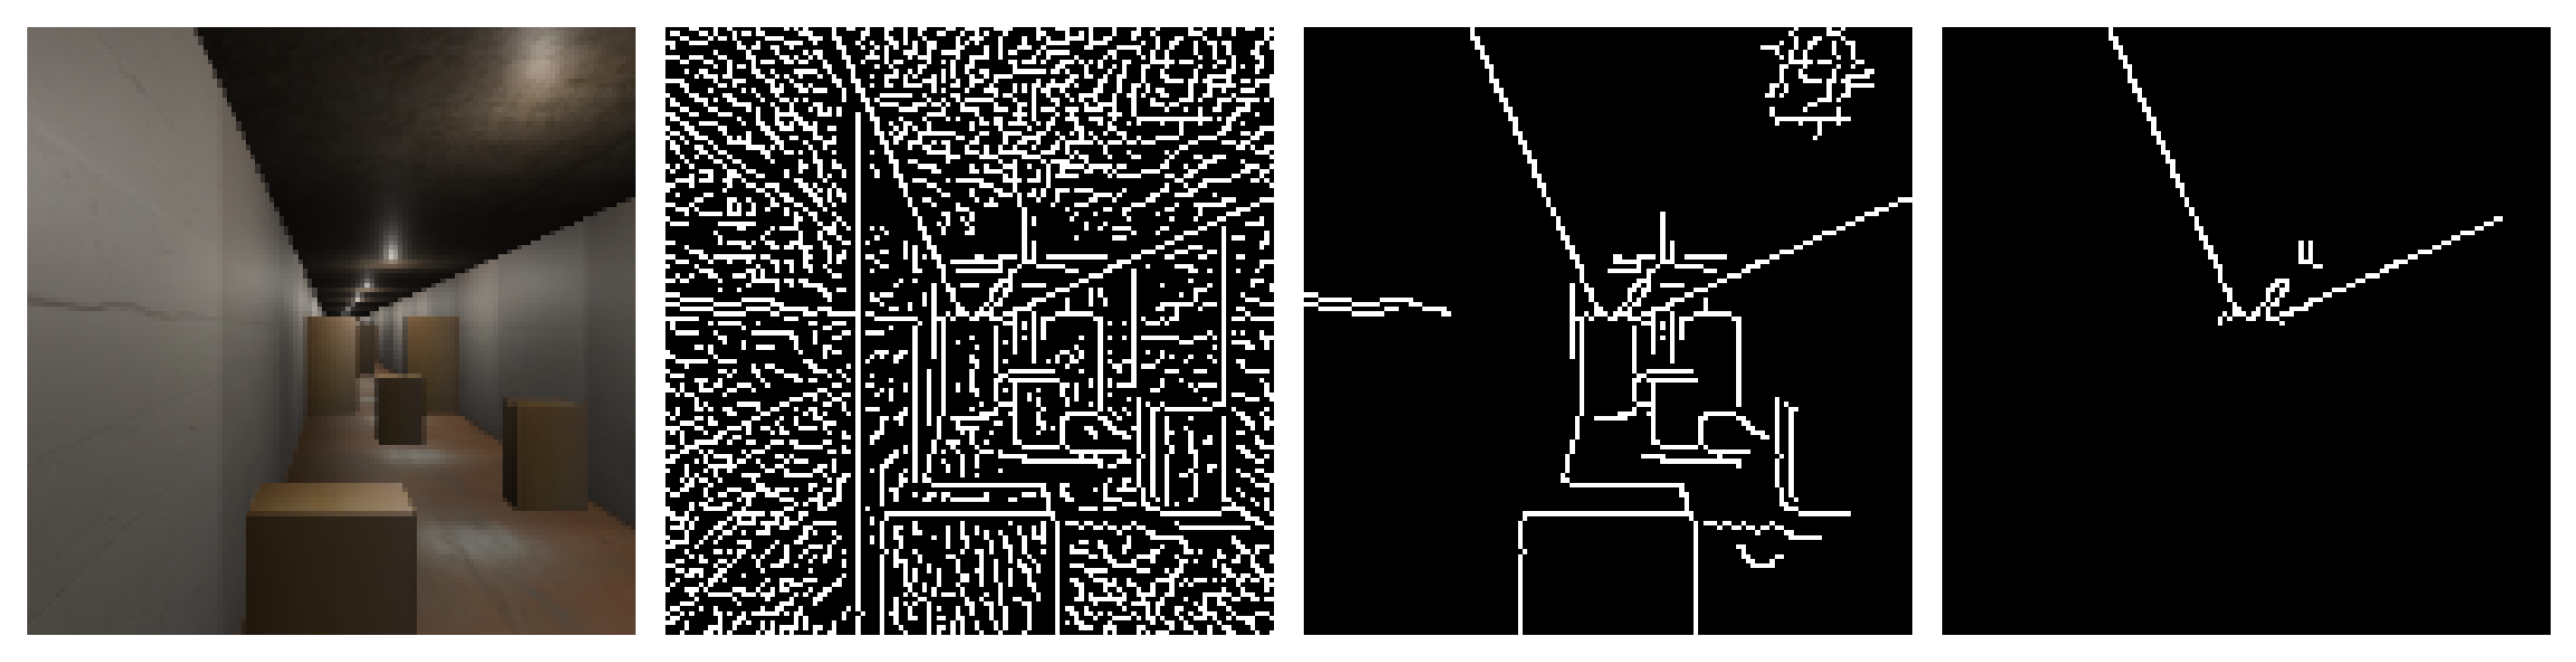

In [15]:
n_figs = len(edges)
fig, axs = plt.subplots(1,n_figs,figsize=(3*n_figs,3), dpi=300)
fig.subplots_adjust(wspace=0.05)
for i, img in enumerate(edges):
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')

fig.savefig("figures/edge_thresholds_5_100_500.png", bbox_inches="tight")

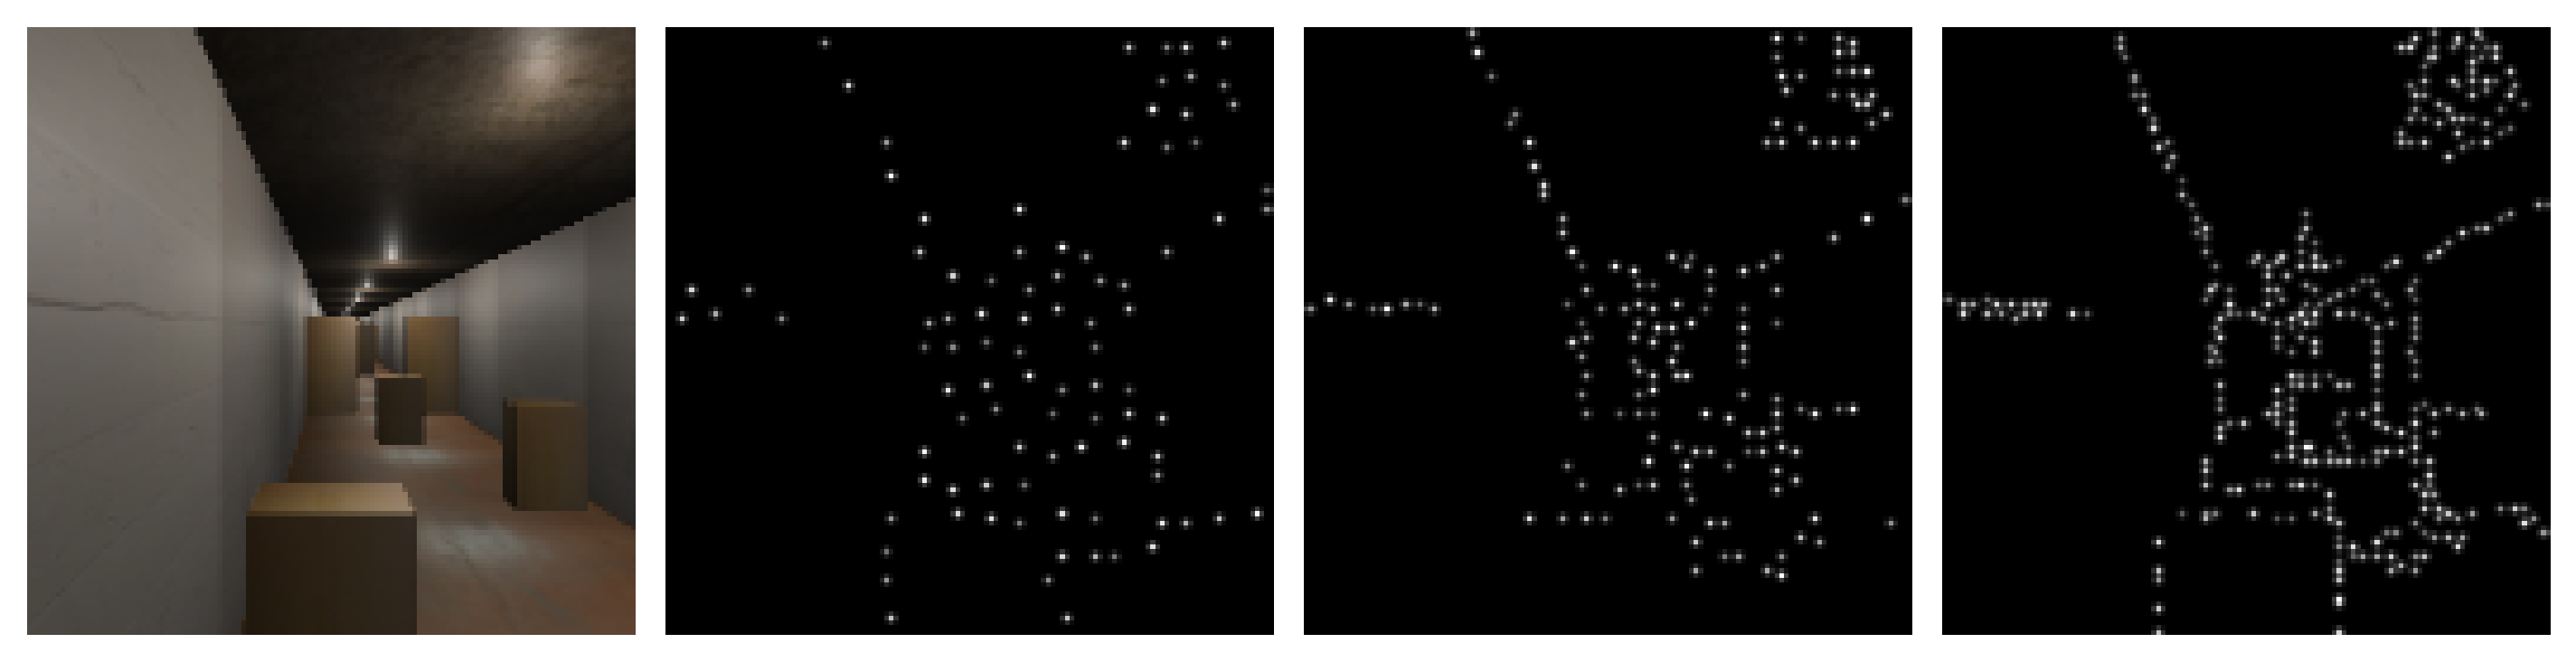

In [16]:
n_figs = len(resolutions)
fig, axs = plt.subplots(1,n_figs,figsize=(3*n_figs,3), dpi=300)
fig.subplots_adjust(wspace=0.05)
for i, img in enumerate(resolutions):
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')

fig.savefig("figures/resolutions_18_34_50.png", bbox_inches="tight")